In [1]:
import argparse
import better_exceptions
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.optim.lr_scheduler import StepLR
import torch.utils.data
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import pretrainedmodels
import pretrainedmodels.utils
from model import get_model
from dataset import FaceDataset
from defaults import _C as cfg
from train import train, AverageMeter, validate

Change data_dir to the direction of the 'appa-real-release' dataset

Download with cmd:

wget http://158.109.8.102/AppaRealAge/appa-real-release.zip

unzip appa-real-release.zip

In [2]:
data_dir = '../appa-real-release'

In [26]:
model = get_model()
start_epoch = 0
checkpoint_dir = Path('checkpoint')
checkpoint_dir.mkdir(parents=True, exist_ok=True)
resume_path = None
tensorboard_dir = 'tensorboard'
opts = []
multi_gpu = False

if resume_path:
    if Path(resume_path).is_file():
        print("=> loading checkpoint '{}'".format(resume_path))
        checkpoint = torch.load(resume_path, map_location="cpu")
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(resume_path, checkpoint['epoch']))
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        print("=> no checkpoint found at '{}'".format(resume_path))

img_size = 256
age_stddev = 1.0
batch_size = 10
learning_rate = 1e-3
step_size = 20
decay_rate = 0.2
num_epochs = 3

In [27]:
train_dataset = FaceDataset(data_dir, "train", img_size=img_size, augment=True, age_stddev=age_stddev)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = FaceDataset(data_dir, "valid", img_size=img_size, augment=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)

scheduler = StepLR(optimizer, step_size=step_size, gamma=decay_rate, last_epoch=start_epoch - 1)
best_val_mae = 10000.0
train_writer = None

if tensorboard_dir is not None:
    opts_prefix = "_".join(opts)
    train_writer = SummaryWriter(log_dir=tensorboard_dir + "/" + opts_prefix + "_train")
    val_writer = SummaryWriter(log_dir=tensorboard_dir + "/" + opts_prefix + "_val")

# Training loop

In [8]:
for epoch in range(start_epoch, num_epochs):
    # train
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, epoch, device)

    # validate
    val_loss, val_acc, val_mae = validate(val_loader, model, criterion, epoch, device)

    if tensorboard_dir is not None:
        train_writer.add_scalar("loss", train_loss, epoch)
        train_writer.add_scalar("acc", train_acc, epoch)
        val_writer.add_scalar("loss", val_loss, epoch)
        val_writer.add_scalar("acc", val_acc, epoch)
        val_writer.add_scalar("mae", val_mae, epoch)

    # checkpoint
    if val_mae < best_val_mae:
        print(f"=> [epoch {epoch:03d}] best val mae was improved from {best_val_mae:.3f} to {val_mae:.3f}")
        model_state_dict = model.module.state_dict() if multi_gpu else model.state_dict()
        torch.save(
            {
                'epoch': epoch + 1,
                'arch': cfg.MODEL.ARCH,
                'state_dict': model_state_dict,
                'optimizer_state_dict': optimizer.state_dict()
            },
            str(checkpoint_dir.joinpath("epoch{:03d}_{:.5f}_{:.4f}.pth".format(epoch, val_loss, val_mae)))
        )
        best_val_mae = val_mae
    else:
        print(f"=> [epoch {epoch:03d}] best val mae was not improved from {best_val_mae:.3f} ({val_mae:.3f})")

    # adjust learning rate
    scheduler.step()

print("=> training finished")
print(f"additional opts: {opts}")
print(f"best val mae: {best_val_mae:.3f}")

100%|███████████| 150/150 [00:18<00:00,  8.16it/s, stage=val, epoch=0, loss=0.471, acc=0.038, correct=0, sample_num=10]


=> [epoch 000] best val mae was improved from 10000.000 to 11.743


  0%|                                                                                          | 0/399 [00:00<?, ?it/s]

=> [epoch 001] best val mae was not improved from 11.743 (11.804)


100%|███████████| 150/150 [00:18<00:00,  8.08it/s, stage=val, epoch=2, loss=0.508, acc=0.038, correct=0, sample_num=10]


=> [epoch 002] best val mae was improved from 11.743 to 11.728
=> training finished
additional opts: []
best val mae: 11.728


In [28]:
x,y = next(iter(train_loader))

In [29]:
x.shape

torch.Size([10, 3, 256, 256])

In [30]:
import matplotlib.pyplot as plt

In [15]:
x.to_numpy()

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [31]:
x[0].transpose(0,2).shape

torch.Size([256, 256, 3])

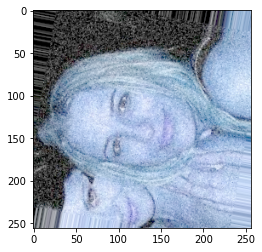

In [32]:
plt.imshow(x[0].transpose(0,2).numpy()/255)

In [42]:
x1 = torch.randn(10,3,224,224)

In [39]:
model._features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [40]:
x1 = model.avgpool(x1)
x1.shape

torch.Size([10, 3, 7, 7])

In [43]:
x1 = model._features(x1)
x1.shape

torch.Size([10, 512, 7, 7])

In [44]:
model

VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxP

In [45]:
model.features

<bound method modify_vggs.<locals>.features of VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [46]:
model.logits

<bound method modify_vggs.<locals>.logits of VGG(
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [51]:
from torchvision.models.vgg import vgg16

In [53]:
model = vgg16(pretrained=True)

In [54]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [60]:
model.classifier[6].out_features = 101

IndexError: index 7 is out of range